# Portuguese Bank Subsciption Prediction

The dataset is based on a telemarketing campaign carried out by Portuguese bank for subscription of a term deposit. The objective is to predict which customers may respond to their marketing campaign to open a term deposit after the campaign.

Dataset link: https://www.wileyindia.com/catalog/product/view/id/6915/s/machine-learning-using-pyhon/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [2]:
bank_df = pd.read_csv("C:\\Users\\Sachin acharya\\Downloads\\Codes-Data-Files\\Machine Learning (Codes and Data Files)\\Data\\bank.csv")

In [3]:
bank_df.head()

,age,job,marital,education,default,balance,housing-loan,personal-loan,current-campaign,previous-campaign,subscribed
0,30,unemployed,married,primary,no,1787,no,no,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,1,0,no


In [5]:
bank_df.shape

(4521, 11)

In [4]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
age                  4521 non-null int64
job                  4521 non-null object
marital              4521 non-null object
education            4521 non-null object
default              4521 non-null object
balance              4521 non-null int64
housing-loan         4521 non-null object
personal-loan        4521 non-null object
current-campaign     4521 non-null int64
previous-campaign    4521 non-null int64
subscribed           4521 non-null object
dtypes: int64(4), object(7)
memory usage: 388.6+ KB


In [6]:
bank_df.subscribed.value_counts()

no     4000
yes     521
Name: subscribed, dtype: int64

By observing the number of subscriptions from the dataset, there is serious imbalance in the dataset. This might lead to accuracy paradox. So the imbalance data has to be treated and either upsampling or downsampling has to be used to balance the data.

# Treating the imbalance in data by using Upsampling

In [7]:
bank_sub_no = bank_df[bank_df.subscribed == 'no']
bank_sub_yes = bank_df[bank_df.subscribed == 'yes']

In [8]:
from sklearn.utils import resample

df_minority_upsampled = resample(bank_sub_yes, replace = True, n_samples = 2000)

In [10]:
#combining the upsampled data with the majority class
new_bank_df = pd.concat([bank_sub_no,df_minority_upsampled])

In [11]:
from sklearn.utils import shuffle

new_bank_df = shuffle(new_bank_df)

Now the dataset is balanced with equal proportions of subsciptions which doesn't lead to any accuracy paradox.

In [14]:
x_features = list(new_bank_df.columns)
x_features.remove('subscribed')
x_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

# Encoding the categorial values

In [16]:
encoded_bank_df = pd.get_dummies(new_bank_df[x_features],drop_first = True)
x = encoded_bank_df

In [19]:
# encoding the 'subscribed' column--->   'yes' is encoded as 1 and 'no' is encoded as 0
y = new_bank_df.subscribed.map( lambda x: int( x == 'yes') )

# Splitting the data into train and test datasets

In [20]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

# Building the model

# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
y_pred = logit.predict(x_test)

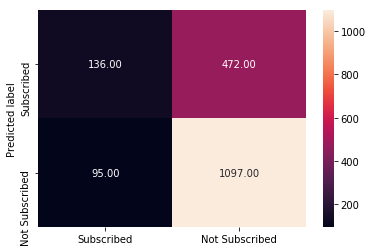

In [27]:
from sklearn import metrics

def draw_cm(actual,predicted):
    cm=metrics.confusion_matrix(actual,predicted,[1,0])
    sns.heatmap(cm,annot = True,fmt='.2f',xticklabels = ['Subscribed','Not Subscribed'],yticklabels = ['Subscribed','Not Subscribed'])
    plt.ylabel('Actual label')
    plt.ylabel('Predicted label')
    plt.show()
    
    
cm = draw_cm(y_test,y_pred)

The model has a very few True positives and large number of False negatives. The best model must have high percentage of true positives.

In [28]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.92      0.79      1192
           1       0.59      0.22      0.32       608

   micro avg       0.69      0.69      0.69      1800
   macro avg       0.64      0.57      0.56      1800
weighted avg       0.66      0.69      0.64      1800



The recall for positive cases is only 0.22 and most are predicted as negatives

In [29]:
#predicting the probability values for test cases
predict_proba_df = pd.DataFrame(logit.predict_proba(x_test))
predict_proba_df.head()

,0,1
0,0.722865,0.277135
1,0.581706,0.418294
2,0.813692,0.186308
3,0.808916,0.191084
4,0.599547,0.400453


In [36]:
# To store actual labels and predicted probabilities
test_results_df = pd.DataFrame({'actual': y_test})
test_results_df = test_results_df.reset_index()
test_results_df['chd_1'] = predict_proba_df.iloc[:,1]
test_results_df.head()

,index,actual,chd_1
0,2275,0,0.277135
1,346,0,0.418294
2,26,0,0.186308
3,37,1,0.191084
4,3700,0,0.400453


In [37]:
# Computing the ROC AUC score
auc_score = metrics.roc_auc_score(test_results_df.actual,test_results_df.chd_1)
auc_score

0.6878007991875662

In [39]:
#plotting the ROC curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

fpr,tpr,thresh = roc_curve(test_results_df['actual'],test_results_df['chd_1'])

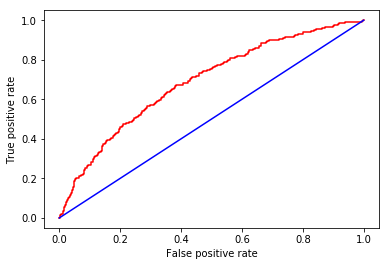

In [41]:
plt.plot(fpr,tpr,color = 'r')
plt.plot(fpr,fpr,color = 'b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

By the ROC AUC score of Logistic Regression, the model does considerably better predictions.

# K - Nearest Neighbor Algorithm

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [45]:
y_pred = knn.predict(x_test)

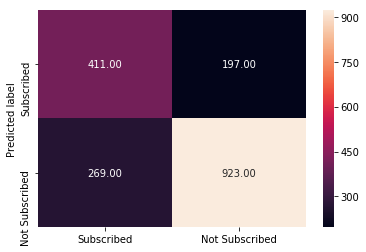

In [46]:
cm = draw_cm(y_test,y_pred)

In [47]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1192
           1       0.60      0.68      0.64       608

   micro avg       0.74      0.74      0.74      1800
   macro avg       0.71      0.73      0.72      1800
weighted avg       0.75      0.74      0.74      1800



The recall for positive cases has improved from 0.22 in Logistic model to 0.68 in K-Nearest Neighbor algorithm

In [48]:
#predicting the probability values for test cases
predict_proba_df = pd.DataFrame(knn.predict_proba(x_test))
predict_proba_df.head()

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.8,0.2


In [49]:
# To store actual labels and predicted probabilities
test_results_df = pd.DataFrame({'actual': y_test})
test_results_df = test_results_df.reset_index()
test_results_df['chd_1'] = predict_proba_df.iloc[:,1]
test_results_df.head()

,index,actual,chd_1
0,2275,0,0.0
1,346,0,0.0
2,26,0,0.0
3,37,1,1.0
4,3700,0,0.2


In [50]:
# Computing the ROC AUC score
auc_score = metrics.roc_auc_score(test_results_df.actual,test_results_df.chd_1)
auc_score

0.8052780598728364

In [51]:
#plotting the ROC curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

fpr,tpr,thresh = roc_curve(test_results_df['actual'],test_results_df['chd_1'])

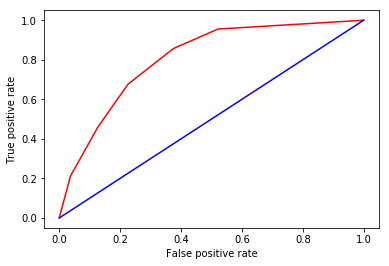

In [52]:
plt.plot(fpr,tpr,color = 'r')
plt.plot(fpr,fpr,color = 'b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Hyper-parameter tuning by using GridSearchCV for K-NN

In [54]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [ {'n_neighbors': range(5,10), 'metric': ['canberra','euclidean','minkowski']} ]
clf = GridSearchCV(KNeighborsClassifier(),tuned_parameters,cv=10,scoring='roc_auc')
clf.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': range(5, 10), 'metric': ['canberra', 'euclidean', 'minkowski']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [57]:
clf.best_score_

0.8347723409405238

In [58]:
clf.best_params_

{'metric': 'canberra', 'n_neighbors': 5}

The K-NN model can be improved by tuning the hyper parameters as k = 5 and metric = canberra. The ROC AUC score has improved from 0.80 to 0.834

# Ensemble methods

# Random forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

rdm_clf = RandomForestClassifier(max_depth = 10,n_estimators = 10)
rdm_clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
y_pred = rdm_clf.predict(x_test)

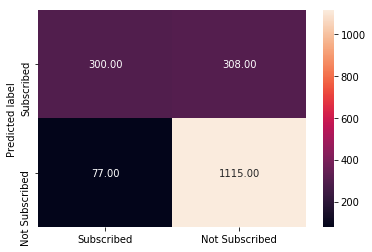

In [61]:
cm = draw_cm(y_test,y_pred)

In [62]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1192
           1       0.80      0.49      0.61       608

   micro avg       0.79      0.79      0.79      1800
   macro avg       0.79      0.71      0.73      1800
weighted avg       0.79      0.79      0.77      1800



The recall for positive cases is just 0.49 and cannot be considered for prediction.

In [79]:
#predicting the probability values for test cases
predict_proba_df = pd.DataFrame(rdm_clfrdm_clfrdm_clf.predict_proba(x_test))
predict_proba_df.head()

,0,1
0,0.750934,0.249066
1,0.686757,0.313243
2,0.906989,0.093011
3,0.469928,0.530072
4,0.626946,0.373054


In [80]:
# To store actual labels and predicted probabilities
test_results_df = pd.DataFrame({'actual': y_test})
test_results_df = test_results_df.reset_index()
test_results_df['chd_1'] = predict_proba_df.iloc[:,1]
test_results_df.head()

,index,actual,chd_1
0,2275,0,0.249066
1,346,0,0.313243
2,26,0,0.093011
3,37,1,0.530072
4,3700,0,0.373054


In [81]:
# Computing the ROC AUC score
auc_score = metrics.roc_auc_score(test_results_df.actual,test_results_df.chd_1)
auc_score

0.8456030885729424

In [82]:
#plotting the ROC curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

fpr,tpr,thresh = roc_curve(test_results_df['actual'],test_results_df['chd_1'])

plt.plot(fpr,tpr,color = 'r')
plt.plot(fpr,fpr,color = 'b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Though the ROC AUC score is 0.84, the recall is just 0.49. So the accuracy can be improved by using hyper parameter tuning.

# Hyper-parameter tuning by using GridSearchCV for Random Forest

In [84]:
tuned_parameters = [{'max_depth' : [10,15],'n_estimators' : [10,20],'max_features': ['sqrt',0.2]}]
radm_clf = RandomForestClassifier()
clf = GridSearchCV(radm_clf,tuned_parameters,cv=5,scoring = 'roc_auc')
clf.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [10, 15], 'n_estimators': [10, 20], 'max_features': ['sqrt', 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [85]:
clf.best_score_

0.9178239373375289

In [86]:
clf.best_params_

{'max_depth': 15, 'max_features': 0.2, 'n_estimators': 20}

# Rebuilding the Random Forest model with the best features

In [87]:
from sklearn.ensemble import RandomForestClassifier

rdm_clf = RandomForestClassifier(max_depth = 15,n_estimators = 20,max_features='auto')
rdm_clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
y_pred = rdm_clf.predict(x_test)

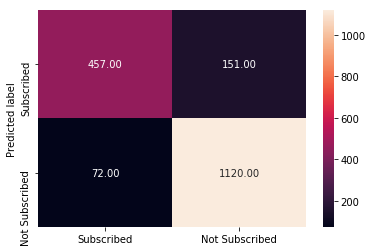

In [89]:
cm = draw_cm(y_test,y_pred)

In [90]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1192
           1       0.86      0.75      0.80       608

   micro avg       0.88      0.88      0.88      1800
   macro avg       0.87      0.85      0.86      1800
weighted avg       0.88      0.88      0.87      1800



The recall and precision for positives has improved and better than both logistic and K-NN models

In [91]:
#predicting the probability values for test cases
predict_proba_df = pd.DataFrame(rdm_clf.predict_proba(x_test))
predict_proba_df.head()

,0,1
0,0.884138,0.115862
1,0.874624,0.125376
2,0.978907,0.021093
3,0.255071,0.744929
4,0.660931,0.339069


In [92]:
# Computing the ROC AUC score
auc_score = metrics.roc_auc_score(test_results_df.actual,test_results_df.chd_1)
auc_score

0.8456030885729424

In [93]:
#plotting the ROC curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

fpr,tpr,thresh = roc_curve(test_results_df['actual'],test_results_df['chd_1'])

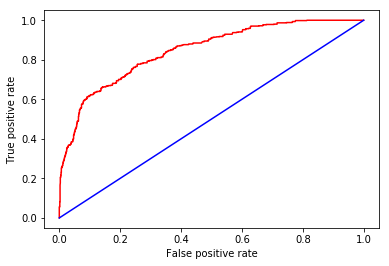

In [94]:
plt.plot(fpr,tpr,color = 'r')
plt.plot(fpr,fpr,color = 'b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

After hyper-parameter tuning, the precision and recall for positive cases has improved with a ROC AUC score 0.84

# Boosting the prediction model

# AdaBoost

In [110]:
from sklearn.ensemble import AdaBoostClassifier

logreg_clf = LogisticRegression()
ada_clf = AdaBoostClassifier(logreg_clf,n_estimators = 50)
ada_clf.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [111]:
y_pred = ada_clf.predict(x_test)

In [112]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1192
           1       0.63      0.16      0.26       608

   micro avg       0.69      0.69      0.69      1800
   macro avg       0.66      0.56      0.53      1800
weighted avg       0.67      0.69      0.62      1800



In [113]:
#predicting the probability values for test cases
predict_proba_df = pd.DataFrame(ada_clf.predict_proba(x_test))
predict_proba_df.head()

,0,1
0,0.504958,0.495042
1,0.501946,0.498054
2,0.507119,0.492881
3,0.507437,0.492563
4,0.501833,0.498167


In [114]:
# To store actual labels and predicted probabilities
test_results_df = pd.DataFrame({'actual': y_test})
test_results_df = test_results_df.reset_index()
test_results_df['chd_1'] = predict_proba_df.iloc[:,1]
test_results_df.head()

,index,actual,chd_1
0,2275,0,0.495042
1,346,0,0.498054
2,26,0,0.492881
3,37,1,0.492563
4,3700,0,0.498167


In [115]:
# Computing the ROC AUC score
auc_score = metrics.roc_auc_score(test_results_df.actual,test_results_df.chd_1)
auc_score

0.68631750044154

In [116]:
#plotting the ROC curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

fpr,tpr,thresh = roc_curve(test_results_df['actual'],test_results_df['chd_1'])

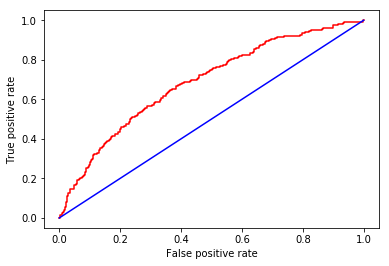

In [117]:
plt.plot(fpr,tpr,color = 'r')
plt.plot(fpr,fpr,color = 'b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

As AdaBoost focusses on misclassified samples, the ROC AUC curve doesnt give much boost to the model. So Gradient Boosting can be used inorder to boost the model for better prediction.

# Improvising the model using Gradient boosting

In [118]:
from sklearn.ensemble import GradientBoostingClassifier

gboost_clf = GradientBoostingClassifier(n_estimators = 500,max_depth=10)
gboost_clf.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [121]:
y_pred = gboost_clf.predict(x_test)

In [122]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1192
           1       0.90      0.93      0.92       608

   micro avg       0.94      0.94      0.94      1800
   macro avg       0.93      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



In [125]:
#predicting the probability values for test cases
predict_proba_df = pd.DataFrame(gboost_clf.predict_proba(x_test))
predict_proba_df.head()

,0,1
0,0.999952,0.000048
1,0.999816,0.000184
2,0.999980,0.000020
3,0.000188,0.999812
4,0.541877,0.458123


In [126]:
# To store actual labels and predicted probabilities
test_results_df = pd.DataFrame({'actual': y_test})
test_results_df = test_results_df.reset_index()
test_results_df['chd_1'] = predict_proba_df.iloc[:,1]
test_results_df.head()

,index,actual,chd_1
0,2275,0,0.000048
1,346,0,0.000184
2,26,0,0.000020
3,37,1,0.999812
4,3700,0,0.458123


In [127]:
# To store actual labels and predicted probabilities
test_results_df = pd.DataFrame({'actual': y_test})
test_results_df = test_results_df.reset_index()
test_results_df['chd_1'] = predict_proba_df.iloc[:,1]
test_results_df.head()

,index,actual,chd_1
0,2275,0,0.000048
1,346,0,0.000184
2,26,0,0.000020
3,37,1,0.999812
4,3700,0,0.458123


In [128]:
# Computing the ROC AUC score
auc_score = metrics.roc_auc_score(test_results_df.actual,test_results_df.chd_1)
auc_score

0.9667920456552456

In [129]:
#plotting the ROC curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

fpr,tpr,thresh = roc_curve(test_results_df['actual'],test_results_df['chd_1'])

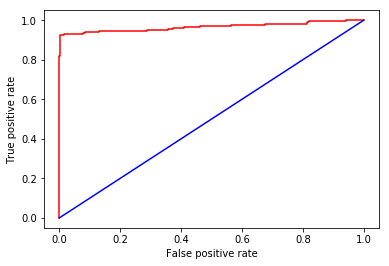

In [130]:
plt.plot(fpr,tpr,color = 'r')
plt.plot(fpr,fpr,color = 'b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Considering the ROC AUC score and ROC curve, the latest model will predict better than the previous ones. But the model might overfit

In [132]:
from sklearn.model_selection import cross_val_score

gboost_clf = GradientBoostingClassifier(n_estimators = 500,max_depth=10)
cv_scores = cross_val_score(gboost_clf,x_train,y_train,cv=10,scoring='roc_auc')
print(cv_scores)

[0.9692425  0.92297916 0.9765483  0.95575924 0.94971709 0.96966128
 0.96771551 0.96016283 0.95804214 0.95169579]


In [133]:
print('mean accuracy: ',np.mean(cv_scores))
print('std deviation: ',np.std(cv_scores))

mean accuracy:  0.9581523830249477
std deviation:  0.014300655100699397


Condisering the cross validation scores and mean,standard deviation of the Gradient Boosting Classifier, we can infer that the model performs at its best for prediction

# Conclusion

By considering the probability of prediction, ROC curve and ROC AUC score, we can conclude that Gradient Boosting algorithm can be used for the prediction of  subsciption of term deposit in the Portuguese Bank.